In [1]:
! pip install -q -U tensor-sensor

In [2]:
import tsensor
tsensor.__version__

'0.1.2'

### NumPy

In [5]:
import numpy as np

n = 200         # number of instances
d = 764         # number of instance features
n_neurons = 100 # how many neurons in this layer?

W = np.random.rand(d,n_neurons)
b = np.random.rand(n_neurons,1)
X = np.random.rand(n,d)
Y = W @ X.T + b  

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 764 is different from 100)

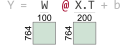

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 764 is different from 100)
Cause: @ on tensor operand W w/shape (764, 100) and operand X.T w/shape (764, 200)

In [6]:
import tsensor
W = np.random.rand(d,n_neurons)
b = np.random.rand(n_neurons,1)
X = np.random.rand(n,d)
with tsensor.clarify() as c:
    Y = W @ X.T + b

In [7]:
c.view.savefig("/tmp/t.svg")

In [8]:
tsensor.astviz("Y = W @ X.T + b")

IncrEvalTrap: W @ X.T

### PyTorch

In [9]:
import torch

n = 200         # number of instances
d = 764         # number of instance features
n_neurons = 100 # how many neurons in this layer?

W = torch.rand(d,n_neurons)
b = torch.rand(n_neurons,1)
X = torch.rand(n,d)
Y = W @ X.T + b  # compute output for one hidden-layer

RuntimeError: mat1 and mat2 shapes cannot be multiplied (764x100 and 764x200)

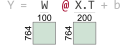

RuntimeError: mat1 and mat2 shapes cannot be multiplied (764x100 and 764x200)
Cause: @ on tensor operand W w/shape [764, 100] and operand X.T w/shape [764, 200]

In [10]:
with tsensor.clarify() as c:
    Y = W @ X.T + b

In [11]:
c.view.savefig("/tmp/torch-mm.svg")

hi


hi


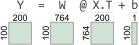

In [12]:
import torch

n = 200         # number of instances
d = 764         # number of instance features
n_neurons = 100 # how many neurons in this layer?

W = torch.rand(n_neurons,d)
b = torch.rand(n_neurons,1)
X = torch.rand(n,d)

def f(): pass

with tsensor.explain() as c:
    f()
    print("hi")
    Y = W @ X.T + b

In [13]:
c.views[0].savefig("/tmp/torch-mm-explain.svg")

In [14]:
with tsensor.explain() as c:
    print("hi")

hi


hi


### TensorFlow

In [ ]:
import tensorflow as tf

n = 200         # number of instances
d = 764         # number of instance features
n_neurons = 100 # how many neurons in this layer?

W = tf.random.uniform((d,n_neurons))
b = tf.random.uniform((n_neurons,1))
X = tf.random.uniform((n,d))
Y = W @ tf.transpose(X) + b  # compute output for one hidden-layer

In [ ]:
with tsensor.clarify() as c:
    Y = W @ tf.transpose(X) + b

In [ ]:
c.view.savefig("/tmp/t.svg")

In [ ]:
tsensor.astviz("Y = W @ tf.transpose(X) + b")

## Sim GRU

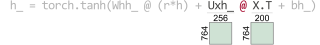

RuntimeError: mat1 and mat2 shapes cannot be multiplied (764x256 and 764x200)
Cause: @ on tensor operand Uxh_ w/shape [764, 256] and operand X.T w/shape [764, 200]

In [17]:
nhidden = 256
Whh_ = torch.eye(nhidden, nhidden)
Uxh_ = torch.randn(d, nhidden)
bh_  = torch.zeros(nhidden, 1)
h = torch.randn(nhidden, 1)  # fake previous hidden state h
r = torch.randn(nhidden, 1)  # fake this computation
X = torch.rand(n,d)          # fake input

with tsensor.clarify() as c:
    h_ = torch.tanh(Whh_ @ (r*h) + Uxh_ @ X.T + bh_)

In [18]:
c.view.savefig("/tmp/torch-gru.png")

File extension .png differs from previous .svg; uses previous.


###  now fix it and show the tree

In [19]:
import torch
import tsensor
nhidden = 256
n = 200         # number of instances
d = 764         # number of instance features
n_neurons = 100 # how many neurons in this layer?

Whh_ = torch.eye(nhidden, nhidden)
Uxh_ = torch.randn(nhidden, d)
bh_  = torch.zeros(nhidden, 1)
h = torch.randn(nhidden, 1)  # fake previous hidden state h
r = torch.randn(nhidden, 1)  # fake this computation
X = torch.rand(n,d)          # fake input

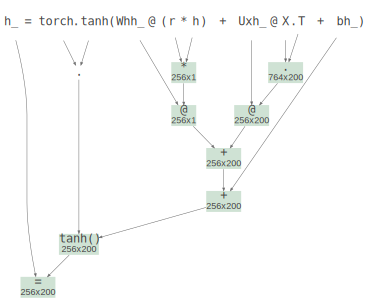

In [20]:
g = tsensor.astviz("h_ = torch.tanh(Whh_ @ (r*h) + Uxh_ @ X.T + bh_)")
g.savefig("/tmp/torch-gru-ast-shapes.svg")
g

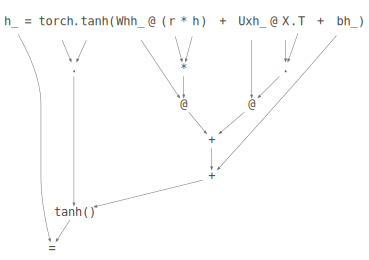

In [21]:
g = tsensor.astviz("h_ = torch.tanh(Whh_ @ (r*h) + Uxh_ @ X.T + bh_)", frame=None)
g.savefig("/tmp/torch-gru-ast.svg")
g

## Make class wrapper

In [22]:
class Linear:
    def __init__(self, d, n_neurons):
        self.W = torch.randn(n_neurons, d)
        self.b = torch.zeros(n_neurons, 1)
    def __call__(self, input):
        return self.W @ input + self.b

In [23]:
import torch

n = 200         # number of instances
d = 764         # number of instance features
n_neurons = 100 # how many neurons in this layer?

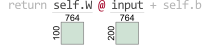

RuntimeError: mat1 and mat2 shapes cannot be multiplied (100x764 and 200x764)
Cause: @ on tensor operand self.W w/shape [100, 764] and operand input w/shape [200, 764]

In [24]:
L = Linear(d,n_neurons)
X = torch.rand(n,d)

with tsensor.clarify() as c:
    Y = L(X)

In [25]:
c.view.savefig('/tmp/t.svg')

## Use nn.Linear

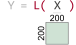

RuntimeError: mat1 and mat2 shapes cannot be multiplied (200x200 and 764x100)
Cause: L(X) tensor arg X w/shape [200, 200]

In [26]:
L = torch.nn.Linear(d, n_neurons)
X = torch.rand(n,n)
with tsensor.clarify() as c:
    Y = L(X)

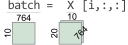

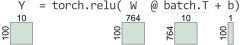

In [27]:
import torch
import tsensor

n = 200                          # number of instances
d = 764                          # number of instance features
n_neurons = 100                  # how many neurons in this layer?
batch_size = 10                  # how many records per batch?
n_batches = n // batch_size

W = torch.rand(n_neurons,d)
b = torch.rand(n_neurons,1)
X = torch.rand(n_batches,batch_size,d)

with tsensor.explain() as e:
    for i in range(n_batches):
        batch = X[i,:,:]
        Y = torch.relu(W @ batch.T + b)

In [28]:
e.views[0].filename, e.views[1].filename

('/var/folders/w1/_nr4stn13lq0rvjdkwh7q8cc0000gn/T/tmp4r0hxew3.svg',
 '/var/folders/w1/_nr4stn13lq0rvjdkwh7q8cc0000gn/T/tmpsy3n2zq6.svg')

### Try to get 4D

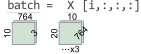

In [29]:
W = torch.rand(n_neurons,d)
b = torch.rand(n_neurons,1)
batch_size = 10
n_batches = n // batch_size
X = torch.rand(n_batches,batch_size,d,3)

with tsensor.explain() as e:
    batch = X[i,:,:,:]

In [30]:
e.views[0].savefig('/tmp/torch-4D.svg')

##  horizontal and vertical vectors

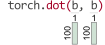

RuntimeError: 1D tensors expected, but got 2D and 2D tensors
Cause: torch.dot(b, b) tensor arg b w/shape [100, 1], arg b w/shape [100, 1]

In [31]:
b = torch.rand(n_neurons,1)
with tsensor.clarify() as c:
    torch.dot(b, b)

In [32]:
c.view.savefig('/tmp/t.svg')

##  Explain

This one is subtle. We use explain to figure out why we get the wrong answer even though there's no exception.

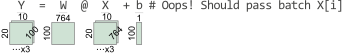

In [33]:
W = torch.rand(n_neurons,d)
b = torch.rand(n_neurons,1)
batch_size = 10
n_batches = n // batch_size
X = torch.rand(n_batches,batch_size,d,3)

with tsensor.explain() as c:
    for i in range(n_batches):
        Y = W @ X + b # Oops! Should pass batch X[i]

In [34]:
Y.shape, d, n_neurons, n, (W @ X).shape

(torch.Size([20, 10, 100, 3]), 764, 100, 200, torch.Size([20, 10, 100, 3]))

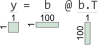

In [35]:
import torch
b = torch.rand(1,n_neurons)
with tsensor.explain() as c:
    y = b @ b.T

In [36]:
c.views[0].savefig('/tmp/t.svg')

In [37]:
import torch
b = torch.rand(n_neurons)
with tsensor.explain() as c:
    y = torch.dot(b, b)

In [38]:
c.views[0].savefig('/tmp/torch-dot.svg')